# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing. 
* canton: swiss canton.
* class_level: school year in swiss system.


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* timestamp: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* session_id: session during which the event took place.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).


### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* validation: used to validate the format of the input.
* solution: solution to question.
* type: type of question that was answered. 


In [496]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = './data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [697]:
import seaborn as sns
from scipy import stats
import datetime

In [729]:
pd.options.mode.chained_assignment = None  # default='warn'

In [497]:
users.head()

,user_id,gender,canton,class_level
0,387604,NaN,NaN,NaN
1,387605,NaN,NaN,NaN
2,387608,NaN,NaN,NaN
3,387615,MALE,SG,Gymnasium - 3. Jahr
4,387643,NaN,NaN,NaN


Let's look at the gender column and what values it takes

In [498]:
users.gender.unique()

array([nan, 'MALE', 'FEMALE', 'STAR'], dtype=object)

In [499]:
users[users.gender == 'STAR'].shape[0] / users.shape[0]

0.033880978459291715

Considering the handout clearly says that there are "only three values: M male, F female or missing", I decided to clean the data and swap 'STAR' (gender neutral) to `NaN`

In [500]:
users.gender = users.gender.apply(lambda g: np.nan if g == 'STAR' else g)
users.gender.unique()

array([nan, 'MALE', 'FEMALE'], dtype=object)

---

In [502]:
events.head()

,event_id,user_id,timestamp,category,action,event_type,transaction_token,session_id,tracking_data
0,62,393211,1621583814885,TASK,VIEW_QUESTION,VIEW,7a10ca52-ffb5-4069-8800-0dc86d778e94,NaN,NaN
1,63,393211,1621583898912,TASK,SUBMIT_ANSWER,CLICK,7a10ca52-ffb5-4069-8800-0dc86d778e94,NaN,NaN
2,64,393211,1621583907207,TASK,NEXT,CLICK,7a10ca52-ffb5-4069-8800-0dc86d778e94,NaN,NaN
3,65,393211,1621583907589,TASK,VIEW_QUESTION,VIEW,88fdcaad-f73b-46a2-b561-d262f2441442,NaN,NaN
4,66,393211,1621584222588,TASK,SUBMIT_ANSWER,CLICK,88fdcaad-f73b-46a2-b561-d262f2441442,NaN,NaN


---

In [503]:
transactions.head(1)

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type
0,1061991,cf99b0d7-279a-4ae0-8ef3-a15514e350b6,387604.0,111K3PY6sbr8ac1mRGpse1,87668,NaN,NaN,1637146446763,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,NaN


Interestingly, the `user_id` column in `transactions` contains non-integer values whereas ids are made of integers virtually everytime. Let's see if the decimal value is indeed necessary or pointless. In the latter, we might as well modify the type of `user_id` so that there is no possible comparaison issue with `user_id` from the User table (which is an integer)

I will start by checking if *all* `user_id`s in the transaction table are indeed integers. The `is_uid_int` Series maps each `user_id` to:
- `True` iff the id (which is a float value) is in fact an integer (i.e. ends with ".0") represented as a float
- `False` otherwise

In [504]:
is_uid_int = transactions['user_id'].apply(lambda uid: uid.is_integer())

Then, I'll count the number of non-integer ids by inverting the array and counting the number of `True` values

In [505]:
(~is_uid_int).sum()

0

I deduce that the conversion is safe!

In [506]:
transactions = transactions.astype({'user_id': 'int64'})
transactions.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type
0,1061991,cf99b0d7-279a-4ae0-8ef3-a15514e350b6,387604,111K3PY6sbr8ac1mRGpse1,87668,NaN,NaN,1637146446763,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,NaN
1,1066631,13e3086b-1c4e-4d28-87a3-0582ccf495c6,387604,111K3PY6sbr8ac1mRGpse1,87668,NaN,NaN,1637233737283,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,NaN
2,1011975,6f292166-86bd-4ec9-81e8-22e9033d571e,387604,111K3PY6sbr8ac1mRGpse1,87668,CORRECT,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1636444658255,1.636445e+12,NaN,PASS,"{""type"": ""MULTIPLE_CHOICE"", ""choices"": [{""cont...",MULTIPLE_CHOICE
3,1020790,79a7d731-a36b-4529-a11b-108b9f877a04,387604,111K3PY6sbr8ac1mRGpse1,87668,CORRECT,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1636561847705,1.636562e+12,NaN,PASS,"{""type"": ""MULTIPLE_CHOICE"", ""choices"": [{""cont...",MULTIPLE_CHOICE
4,1061970,a45b6464-371e-47f4-842c-34f9e345b4ec,387604,111K3PY6sbr8ac1mRGpse1,87668,CORRECT,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1637146373965,1.637146e+12,NaN,PASS,"{""type"": ""MULTIPLE_CHOICE"", ""choices"": [{""cont...",MULTIPLE_CHOICE


## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [507]:
users['user_id'].nunique()

13695

#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

In [508]:
transactions_per_user = transactions[['user_id']].copy()
transactions_per_user['transaction_count'] = 1
transactions_per_user = transactions_per_user.groupby('user_id').agg('sum')[['transaction_count']]
transactions_per_user.head()

,transaction_count
user_id,
387604,257
387605,871
387608,294
387615,270
387643,27


In [509]:
users_with_trans = users.join(transactions_per_user, on = 'user_id')
users_with_trans['transaction_count'] = users_with_trans['transaction_count'].fillna(0)
users_with_trans = users_with_trans.astype({'transaction_count': 'int64'})
users_with_trans.head()

,user_id,gender,canton,class_level,transaction_count
0,387604,NaN,NaN,NaN,257
1,387605,NaN,NaN,NaN,871
2,387608,NaN,NaN,NaN,294
3,387615,MALE,SG,Gymnasium - 3. Jahr,270
4,387643,NaN,NaN,NaN,27


array([[<AxesSubplot:title={'center':'transaction_count'}>]], dtype=object)

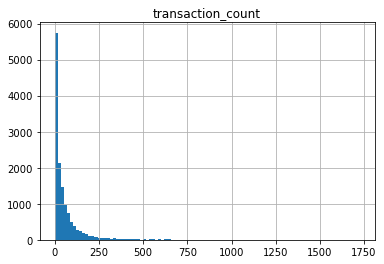

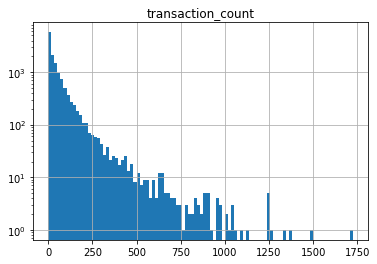

In [671]:
users_with_trans.hist(column = 'transaction_count', bins=100)
users_with_trans.hist(column = 'transaction_count', log=True, bins=100)

We are looking at a power law. Most of the people do very few transactions, and very few people do lot of transactions

#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

In [511]:
top_actions = events.groupby('action').agg('count')[['event_id']]
top_actions = top_actions.rename(columns = {"event_id": "action_count"})
top_actions = top_actions.sort_values(by = 'action_count', ascending = False)
top_actions = top_actions[:10]
top_actions

,action_count
action,
PAGE_VISIT,653725
REVIEW_TASK,513389
SUBMIT_ANSWER,419862
NAVIGATE_DASHBOARD,350821
NEXT,277020
WINDOW_VISIBLE_FALSE,240660
WINDOW_VISIBLE_TRUE,199287
VIEW_QUESTION,154592
OPEN_FEEDBACK,87071


<AxesSubplot:title={'center':'Proportion of the 10 most popular event actions'}, ylabel='action_count'>

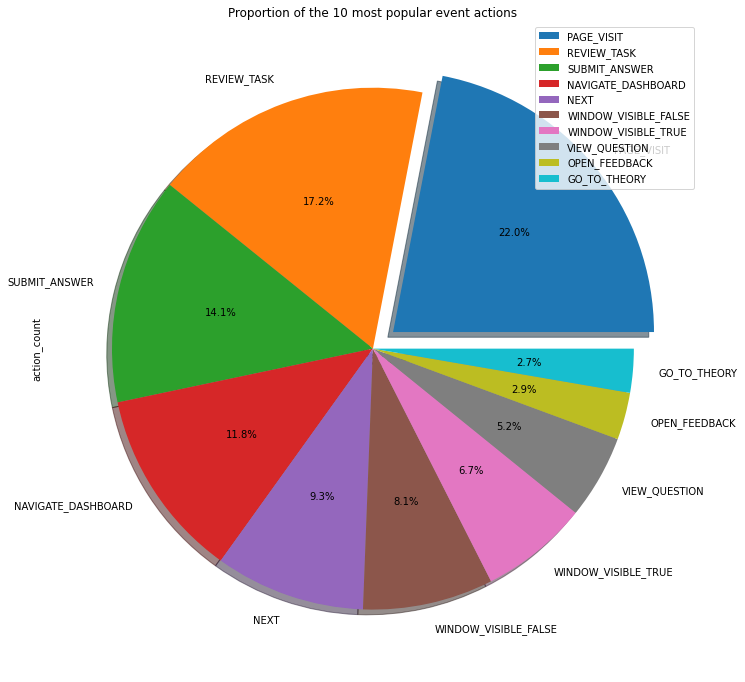

In [512]:
top_actions.plot.pie(
    y='action_count', figsize = (16, 12), autopct='%1.1f%%', shadow=True,
    title='Proportion of the 10 most popular event actions',
    explode=(0.1,) + (0,) * 9
)

The three actions `PAGE_VISIT`, `REVIEW_TASK`, and `SUBMIT_ANSWER` account for more than half of all the actions!

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

In [513]:
num_questions = events[events.action == 'SUBMIT_ANSWER'][['user_id']].copy()
num_questions['num_questions'] = 1
num_questions = num_questions.groupby('user_id').agg('sum')

In [514]:
num_events = events[['user_id']].copy()
num_events['num_events'] = 1
num_events = num_events.groupby('user_id').agg('sum')

In [515]:
percentage_correct = events[events.action == 'SUBMIT_ANSWER'][['user_id', 'transaction_token']].copy()
percentage_correct = percentage_correct.drop_duplicates()
percentage_correct = percentage_correct.join(
    transactions[['transaction_token', 'evaluation']].copy().set_index('transaction_token'), 
    on = 'transaction_token'
)

In [516]:
percentage_correct

,user_id,transaction_token,evaluation
1,393211,7a10ca52-ffb5-4069-8800-0dc86d778e94,NaN
4,393211,88fdcaad-f73b-46a2-b561-d262f2441442,NaN
9,393211,a75eb7b4-b2c2-47d4-9200-27980c175037,NaN
14,393211,61eb829d-bdda-4107-86af-ad9a14a7bdc9,NaN
17,393211,30ff0d8a-865d-460b-9177-b698a52b0d5c,NaN
...,...,...,...
3465529,404540,87832f2d-af7b-41f2-8321-953473f1d0fa,WRONG
3465532,404556,dd8cd76c-0a95-4b4e-9693-e0cb4d43bd25,WRONG
3465540,404550,8b1b72d5-551c-49fe-a4e8-a268a2956909,CORRECT
3465554,404560,9edfed2d-ebe8-4b0e-873c-9ba13e6541b3,CORRECT


In [517]:
def evaluation_to_points(e):
    if e == 'CORRECT':
        return 1.0
    elif e == 'PARTIAL':
        return 0.5
    else:
        return 0.0

percentage_correct['evaluation_points'] = percentage_correct['evaluation'].apply(lambda e: evaluation_to_points(e))

:information_source: note that I decided to grade as follows:
- 1 point for correct answers (`CORRECT`)
- 0.5 point for partially correct answers (`PARTIAL`)
- 0 point for wrong answers (`WRONG`)
- 0 point for missing evaluation (`nan`)

In [518]:
percentage_correct['evaluation_count'] = 1.0

The lowest possible value of `evalution_count` in the aggregated `evaluation_per_user` dataframe is $1.0$ (see line above). This corresponds to a student that answered only a single question. We thus cannot run into divisions by 0

In [519]:
evaluation_per_user = percentage_correct.groupby('user_id').agg('sum')
evaluation_per_user['percentage_correct'] = evaluation_per_user['evaluation_points'] / evaluation_per_user['evaluation_count']
evaluation_per_user.head()

,evaluation_points,evaluation_count,percentage_correct
user_id,,,
387604,52.0,97.0,0.536082
387605,119.0,217.0,0.548387
387608,46.0,54.0,0.851852
387615,12.5,15.0,0.833333
387644,23.5,30.0,0.783333


In [520]:
num_reading = events[events.action == 'GO_TO_SESSION'][['user_id']].copy()
num_reading['num_reading'] = 1
num_reading = num_reading.groupby('user_id').agg('sum')

Now that we computed all the columns, let's put everything together!

In [521]:
users_agg = users[['user_id', 'gender']].copy()
users_agg = users_agg.set_index('user_id')

users_agg = users_agg.join(num_questions, on = 'user_id')
users_agg = users_agg.join(num_events, on = 'user_id')
users_agg = users_agg.join(evaluation_per_user[['percentage_correct']], on = 'user_id')
users_agg = users_agg.join(num_reading, on = 'user_id')

users_agg.head()

,gender,num_questions,num_events,percentage_correct,num_reading
user_id,,,,,
387604,NaN,97.0,2606.0,0.536082,NaN
387605,NaN,217.0,3331.0,0.548387,1.0
387608,NaN,54.0,866.0,0.851852,NaN
387615,MALE,15.0,492.0,0.833333,NaN
387643,NaN,NaN,4.0,NaN,NaN


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

In [522]:
users_agg.describe()

,num_questions,num_events,percentage_correct,num_reading
count,9046.000000,10113.000000,9046.000000,97.000000
mean,46.414106,342.683576,0.566094,1.876289
std,79.436277,577.384662,0.269834,1.522455
min,1.000000,1.000000,0.000000,1.000000
25%,10.000000,79.000000,0.500000,1.000000
50%,23.000000,173.000000,0.641841,1.000000
75%,50.000000,365.000000,0.733333,2.000000
max,1054.000000,10044.000000,1.000000,10.000000


Let's first look at the gender distribution ignoring the values marked as `nan`

Percentage of females :	 60.04%
Percentage of males :	 39.96%


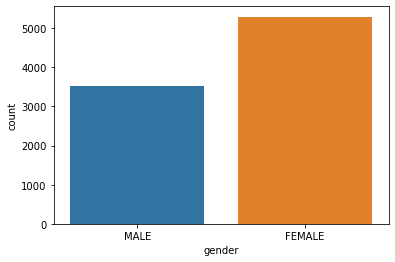

In [564]:
q_all = users_agg[users_agg.gender == 'MALE'].shape[0] + users_agg[users_agg.gender == 'FEMALE'].shape[0]
q_males = users_agg[users_agg.gender == 'MALE'].shape[0] / q_all

print(f'Percentage of females :\t {(1 - q_males) * 100:.2f}%')
print(f'Percentage of males :\t {q_males * 100:.2f}%')

ax = sns.countplot(x = 'gender', data = users_agg)

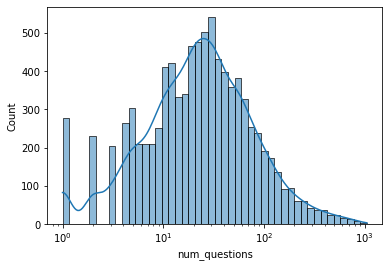

In [545]:
ax = sns.histplot(data = users_agg, x = 'num_questions', kde = True, log_scale=True)

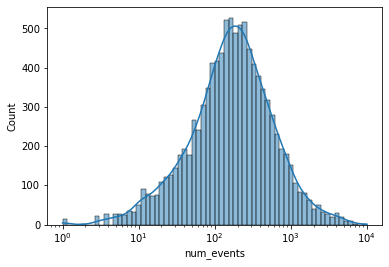

In [566]:
ax = sns.histplot(data = users_agg, x = 'num_events', kde = True, log_scale=True)

There is a total of 13695 recorded scores
There is a total of 7458 recorded scores that are neither 0% nor 100%


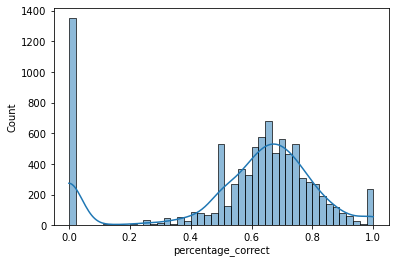

In [581]:
print(f'There is a total of {users_agg.shape[0]} recorded scores')

users_agg_normal_score = users_agg[users_agg.percentage_correct > 0]
users_agg_normal_score = users_agg_normal_score[users_agg_normal_score.percentage_correct < 1]

print(f'There is a total of {users_agg_normal_score.shape[0]} recorded scores that are neither 0% nor 100%')

ax = sns.histplot(data = users_agg, x = 'percentage_correct', kde = True)

<AxesSubplot:xlabel='percentage_correct', ylabel='Count'>

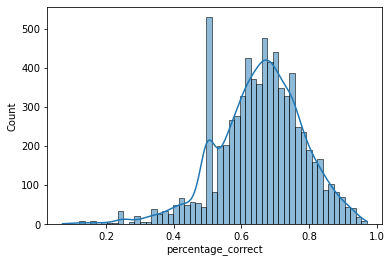

In [580]:
sns.histplot(data = users_agg_normal_score, x = 'percentage_correct', kde = True)

There are a total of 97 non-nan datapoints


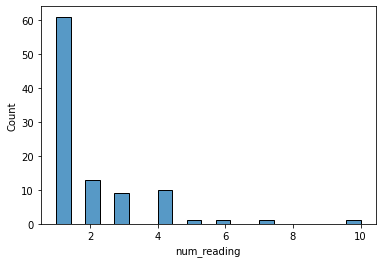

In [568]:
print(f'There are a total of {users_agg[users_agg.num_reading >= 0].shape[0]} non-nan datapoints')

ax = sns.histplot(data = users_agg, x = 'num_reading')

Let's look at the plot in detail and check for anomalies:

- `gender`: nothing suspicious, we are dealing with a dataset w/ 60% females
- `num_questions`: looks "somewhat" like a normal distribution ONLY because there's a log scale on the `x` axis. We are dealing with a heavy-tailed distribution
- `num_events`: same as `num_questions`
- `percentage_correct`: this one is interesting. Excluding people with 0% score and 100% score (which could be bots or students answering randomly for bad scores and teachers for high scores), we have a distribution that would look like a Gaussian (except for the 50% spike). Without excluding these people, we are looking at a distribution with 3 anomalies (0%, 50%, and 100%)
- `num_reading`: this one is unusual. Very few students are using this functionality (go to theory) and thus we have very few datapoints (97 in total). We cannot thus have a good representation of the distribution with such low numbers

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

I will add two new features: `answer_time` & `num_visits`:
- `answer_time`: average time the student takes to answer the questions
- `num_visits`: number of times the student visited the platform

First, I need to get rid of transactions with missing start or end time

In [590]:
transactions_timed = transactions[transactions.commit_time > 0]
transactions_timed = transactions_timed[transactions_timed.start_time > 0]

print(f'Kept {transactions_timed.shape[0] / transactions.shape[0] * 100:.2f}% of the transactions')

Kept 70.98% of the transactions


In [596]:
transactions_timed['answer_time'] = transactions_timed['commit_time'] - transactions_timed['start_time']

In [606]:
transactions_timed_per_user = transactions_timed[['user_id', 'answer_time']].groupby('user_id').agg('mean')

In [607]:
users_agg = users_agg.join(transactions_timed_per_user, on = 'user_id')

---

In [629]:
events_session = events[events.session_id > 0][['user_id', 'session_id']]

print(f'Kept {events_session.shape[0] / events.shape[0] * 100:.2f}% of the events')

Kept 37.69% of the events


In [630]:
events_session = events_session.drop_duplicates() # keeping only one (uid, ssid) tuple

In [632]:
events_session_per_user = events_session.groupby('user_id').agg('count')
events_session_per_user = events_session_per_user.rename(columns = {"session_id": "num_visits"})

In [634]:
users_agg = users_agg.join(events_session_per_user, on = 'user_id')

Let's now look at the result:

In [635]:
users_agg.head()

,gender,num_questions,num_events,percentage_correct,num_reading,answer_time,num_visits
user_id,,,,,,,
387604,NaN,97.0,2606.0,0.536082,NaN,9.978827e+07,38.0
387605,NaN,217.0,3331.0,0.548387,1.0,8.368417e+06,60.0
387608,NaN,54.0,866.0,0.851852,NaN,5.122830e+06,7.0
387615,MALE,15.0,492.0,0.833333,NaN,8.119302e+07,2.0
387643,NaN,NaN,4.0,NaN,NaN,1.215500e+08,NaN


(See above for a full feature description)

The two features are interesting to explore for these reasons:
- `answer_time`: I expect a bimodal distribution (some people answer very fast, and most of the people slower)
- `num_visits`: I expect an "anomaly" at 1 visit (peak) and then a steady decline

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

In [645]:
users_agg[['answer_time', 'num_visits']].describe()

,answer_time,num_visits
count,1.028200e+04,7878.000000
mean,2.024277e+07,9.872049
std,1.576585e+08,17.474271
min,1.803500e+03,1.000000
25%,5.268510e+04,2.000000
50%,9.226326e+04,5.000000
75%,3.346048e+05,10.000000
max,6.557968e+09,244.000000


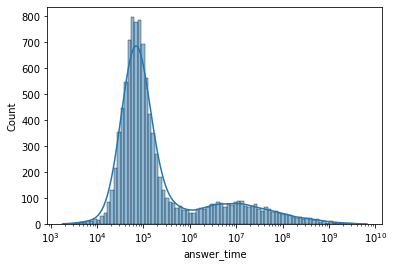

In [641]:
ax = sns.histplot(data = users_agg, x = 'answer_time', kde = True, log_scale = True)

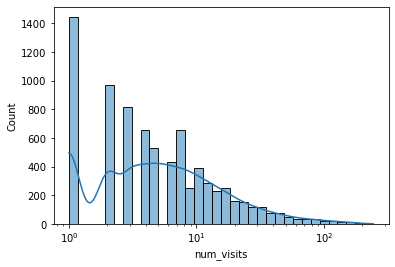

In [640]:
ax = sns.histplot(data = users_agg, x = 'num_visits', kde = True, log_scale = True)

Regarding the `num_visits`, my hypothese is confirmed! We indeed observe a peak at 1 visit, and then a steady decline (keep in mind the log scale)

Regarding the average answer time `answer_time`, It is not at all what I expected! In reality, we observe most people answering in a "normal" amount of time ($~10^5$ here) and some people being slower

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

Let's first take a look at the possible relation between the number of questions answered and the percentage of correct answers. We may expect that students with higher number of questions answered get higher percentage of correct answers (since they trained for longer)

In [669]:
users_agg_no_nan = users_agg[users_agg.num_questions >= 0]

r, p = stats.pearsonr(users_agg_no_nan['num_questions'], users_agg_no_nan['percentage_correct'])

print(f'Linear correlation of coefficient {r:.5f} with p-value = {p}')

Linear correlation of coefficient 0.14158 with p-value = 1.0087130776707611e-41


<AxesSubplot:xlabel='num_questions', ylabel='percentage_correct'>

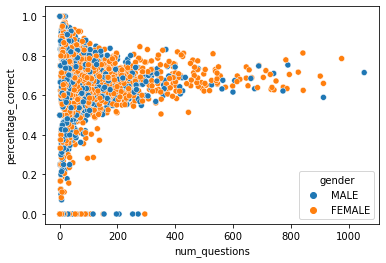

In [657]:
sns.scatterplot(data = users_agg, x = 'num_questions', y = 'percentage_correct', hue = 'gender')

It looks like (eyeballed) we are approching a rate of 2 questions correct out of 3 (66.6%). There's a very small linear correlation (as we can clearly see in the scatterplot)

BONUS: Additionally, there does not seem to be any difference induced by gender

---

A more simplistic comparaison could be between the number of questions answered and the amount of events produced

In [668]:
users_agg_no_nan = users_agg[users_agg.num_questions >= 0]
users_agg_no_nan = users_agg_no_nan[users_agg_no_nan.num_events >= 0]

r, p = stats.pearsonr(users_agg_no_nan['num_questions'], users_agg_no_nan['num_events'])

print(f'Linear correlation of coefficient {r:.5f} with p-value = {p}')

Linear correlation of coefficient 0.93401 with p-value = 0.0


<AxesSubplot:xlabel='num_questions', ylabel='num_events'>

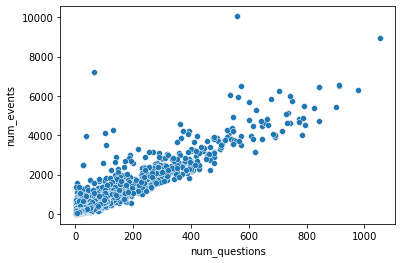

In [661]:
sns.scatterplot(data = users_agg, x = 'num_questions', y = 'num_events')

As expected, there seems to be a strong linear correlation between the two features (which is expected since the more questions you answer, the more events you produce). This is backed up by a pearson coefficient of 0.93 with *very* small p-value

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps. 

You can limit the number of weeks to 13, i.e. for each user we just look at the first 13 weeks of data.
Yoy may change and justify your choice for the number of weeks.

In [819]:
df_weekly = events[['user_id', 'action', 'timestamp', 'transaction_token']].copy()
df_weekly = df_weekly.sort_values(by = ['user_id', 'timestamp'])

df_weekly['num_questions'] = df_weekly['action'] == 'SUBMIT_ANSWER' # true iff action is submit answer
df_weekly['num_reading'] = df_weekly['action'] == 'GO_TO_SESSION'   # true iff action is go to session
df_weekly['num_events'] = 1

In [820]:
# Join the evaluations from the transactions table
df_weekly = df_weekly.join(
    transactions[['transaction_token', 'evaluation']].copy().set_index('transaction_token'), 
    on = 'transaction_token'
)

In [821]:
# Convert the timestamp to the absolute week number (from 1st january 1970)
df_weekly['week_epoch'] = df_weekly['timestamp'] // (1000 * 3600 * 24 * 7)

In [822]:
# Setup the initial column 'week' (which is the relative week)
df_weekly['week'] = np.nan

# Fill in the 'week' column with relative week
last_week = -1
last_week_epoch = -1

last_uid = -1

for index, row in df_weekly.iterrows():   
    uid, week_epoch = row['user_id'], row['week_epoch']
    
    if uid != last_uid:
        last_uid = uid
        last_week = -1
        last_week_epoch = -1
    
    if week_epoch > last_week_epoch:
        last_week_epoch = week_epoch
        last_week += 1

    df_weekly.loc[index, 'week'] = last_week

In [823]:
# Remove useless columns
df_weekly = df_weekly.drop(['timestamp', 'transaction_token', 'week_epoch'], axis = 1)

In [824]:
# Limit the users to their first 13 weeks
df_weekly = df_weekly[df_weekly.week <= 13]

In [825]:
# Converting evaluation to points (see task 2 for more info)
df_weekly['evaluation_points'] = df_weekly['evaluation'].apply(lambda e: evaluation_to_points(e))

In [839]:
df_weekly = df_weekly.groupby(['user_id', 'week']).agg('sum')

In [840]:
# Compute the "correct answers" percentage based on the number of questions and the evaluation
def compute_percentage(row):
    if row.num_questions == 0:
        return np.nan
    else:
        return row.evaluation_points / row.num_questions

df_weekly['percentage_correct'] = df_weekly.apply(lambda row: compute_percentage(row), axis = 1)

In [841]:
df_weekly = df_weekly.reset_index()

In [842]:
# Reorder columns
df_weekly = df_weekly[['user_id', 'week', 'num_events', 'num_questions', 'percentage_correct', 'num_reading']]

In [843]:
df_weekly.head()

,user_id,week,num_events,num_questions,percentage_correct,num_reading
0,387604,0.0,1,0,NaN,0
1,387604,1.0,1,0,NaN,0
2,387604,2.0,7,0,NaN,0
3,387604,3.0,25,0,NaN,0
4,387604,4.0,12,0,NaN,0


#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

I will choose the first two features `num_events` and `num_questions`:
- for `num_events`, I expect to have a constant amount over the weeks with a peak at the beginning (we can imagine people being very active the first week and slowly loosing interest over the weeks)
- for `num_questions`, I expect the same thing as `num_events`. 

Note: I chose these two similar features (same hypotheses) because I want to see if they follow the same trend over time (e.g. some people could be answering a lot of questions at the beginning and then only browsing through the website)

<AxesSubplot:xlabel='week', ylabel='num_events'>

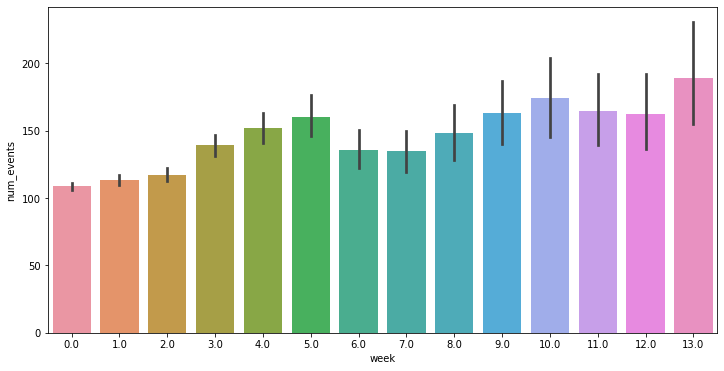

In [853]:
plt.figure(figsize = (12,6))
sns.barplot(x = 'week', y = 'num_events', data = df_weekly)

<AxesSubplot:xlabel='week', ylabel='num_questions'>

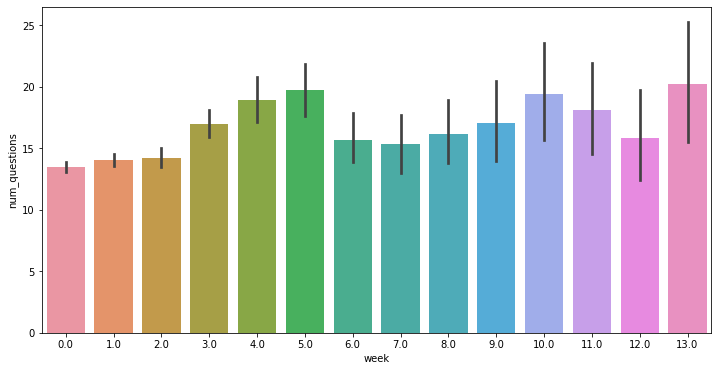

In [854]:
plt.figure(figsize = (12,6))
sns.barplot(x = 'week', y = 'num_questions', data = df_weekly)

Both distribution look indeed similar! However, I was completely wrong concerning the peak at week 0. It seems that students on Learnavi are constent both with their attendance and the fact they keep answering questions instead of going the simple route of scanning the theory rapidely and wandering off.

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



Idea: compare the (average) number of questions answered by degree (`class_level`). I expect a distribution that looks like a $U$ shape, here's why:
- for lower levels: I expect the courses to have a lot of questions (that's what is often done for children) $\implies$ more questions solved (than middle levels)
- for middle levels: nothing in particular (base value)
- for higher levels: I expect people to stay/stick longer per session (than middle levels)

To reduce the graph complexity, I will only keep the top-15 most represented class levels

In [872]:
list(users.class_level.value_counts()[:15].index)

['Gymnasium - 1. Jahr',
 'Gymnasium - 2. Jahr',
 'Kurzzeitgymnasium - 1. Jahr',
 'Langzeitgymnasium - 3. Jahr',
 'Kurzzeitgymnasium - 2. Jahr',
 'Gymnasium - 3. Jahr',
 'FMS - 1. Jahr',
 'Langzeitgymnasium - 4. Jahr',
 'Gymnasium - 1. Jahr (GYM1)',
 'Gymnasium - 4. Jahr',
 'Langzeitgymnasium - 1. Jahr',
 'Langzeitgymnasium - 2. Jahr',
 'FMS - 3. Jahr',
 'FMS - 2. Jahr',
 'Kurzzeitgymnasium - 3. Jahr']

In [873]:
# I ordered the levels as best as I could (from youger to older)
levels_ordered = [
    'FMS - 1. Jahr',
    'Gymnasium - 1. Jahr',
    'Gymnasium - 1. Jahr (GYM1)',
    'Langzeitgymnasium - 1. Jahr',
    'FMS - 2. Jahr',
    'Gymnasium - 2. Jahr',
    'Langzeitgymnasium - 2. Jahr',
    'Kurzzeitgymnasium - 1. Jahr',
    'FMS - 3. Jahr',
    'Gymnasium - 3. Jahr',
    'Langzeitgymnasium - 3. Jahr',
    'Kurzzeitgymnasium - 2. Jahr',
    'Gymnasium - 4. Jahr',
    'Langzeitgymnasium - 4. Jahr',
    'Kurzzeitgymnasium - 3. Jahr'
]

In [883]:
questions_per_user = events[events.action == 'SUBMIT_ANSWER']
questions_per_user['num_questions'] = 1
questions_per_user = questions_per_user[['user_id', 'num_questions']]
questions_per_user = questions_per_user.groupby('user_id').agg('count')
questions_per_user.head()

,num_questions
user_id,
387604,97
387605,217
387608,54
387615,15
387644,30


In [905]:
users_questions = users[['user_id', 'class_level']]
users_questions = users_questions.join(questions_per_user, on = 'user_id')

# Transform people that answered no question from 'nan' to 0
users_questions['num_questions'] = users_questions.num_questions.fillna(0)

# Only keep relevant features
users_questions = users_questions[['class_level', 'num_questions']]

# Only keep top15 most represented class levels
users_questions = users_questions[users_questions.class_level.isin(levels_ordered)]

level_questions = users_questions.groupby('class_level').agg('mean')
level_questions = level_questions.reset_index()
level_questions.head()

,class_level,num_questions
0,FMS - 1. Jahr,41.197889
1,FMS - 2. Jahr,53.524064
2,FMS - 3. Jahr,27.879397
3,Gymnasium - 1. Jahr,63.353164
4,Gymnasium - 1. Jahr (GYM1),36.038690


<AxesSubplot:xlabel='class_level', ylabel='num_questions'>

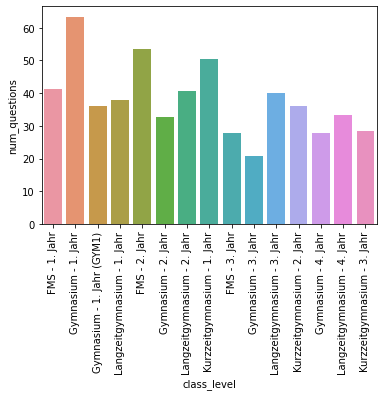

In [909]:
plt.xticks(rotation=90)
sns.barplot(x = 'class_level', y = 'num_questions', data = level_questions, order = levels_ordered)

Well, turns out I could not be more wrong... There's absolutely no $U$ shape in the horizon and I cannot distinguish any other pattern in the graph. We may be able to find something by ordering wrt. to "type" of levels (e.g. FMS, then gymnasium, ...)

In [910]:
levels_separated = [
    'FMS - 1. Jahr',
    'FMS - 2. Jahr',
    'FMS - 3. Jahr',
    
    'Kurzzeitgymnasium - 1. Jahr',
    'Kurzzeitgymnasium - 2. Jahr',
    'Kurzzeitgymnasium - 3. Jahr',
    
    'Gymnasium - 1. Jahr',
    'Gymnasium - 2. Jahr',
    'Gymnasium - 3. Jahr',
    'Gymnasium - 4. Jahr',
    
    'Gymnasium - 1. Jahr (GYM1)',
    
    'Langzeitgymnasium - 1. Jahr',
    'Langzeitgymnasium - 2. Jahr',
    'Langzeitgymnasium - 3. Jahr',
    'Langzeitgymnasium - 4. Jahr'
]

<AxesSubplot:xlabel='class_level', ylabel='num_questions'>

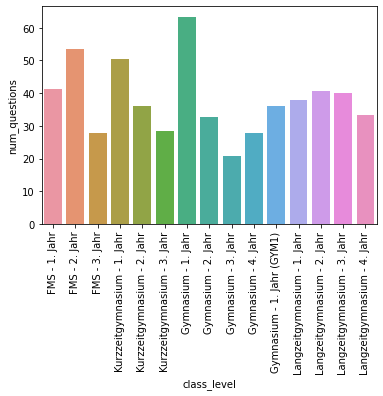

In [911]:
plt.xticks(rotation=90)
sns.barplot(x = 'class_level', y = 'num_questions', data = level_questions, order = levels_separated)

Once again, nothing particularly noteworthy